In [1]:
# In this code we extract and scale the labels for each image, train and validate the dataset 
# on AlexNet model for 400 output classes

In [18]:
# Import cell
import torch
import torch.nn as nn
import math
import numpy as np
from collections import OrderedDict

import torchvision.transforms as transforms
import torchvision
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import seaborn as sns

# image loading
import os
from PIL import Image

# training process
from sklearn import model_selection
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn import metrics
import random 

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Let's start by defining functions used to import and show  data and evaluate results

In [44]:
################## DATA LOADERS ###############
def read_img(root, filedir, transform=None):
    # Data loading
    with open(filedir, 'r') as f:
        lines = f.readlines()  
    output = []    
    for line in lines:
        linesplit = line.split('\n')[0].split(' ')
        #print(linesplit)
        addr = linesplit[0]
        target = torch.Tensor([float(linesplit[1])])
        img = Image.open(os.path.join(root, addr)).convert('RGB')

        if transform is not None:
            img = transform(img)
        
        output.append([img, target])

    return output


################## DATA ANALYSIS ###############
def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()
        
################## PERFORMANCE ANALYSIS ###############      
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

num_classes = 1000

In [3]:
# The following code creates the AlexNet

In [45]:
################## AlexNet ##################
def bn_relu(inplanes):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True))

def bn_relu_pool(inplanes, kernel_size=3, stride=2):
    return nn.Sequential(nn.BatchNorm2d(inplanes), nn.ReLU(inplace=True), nn.MaxPool2d(kernel_size=kernel_size, stride=stride))

class AlexNet(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, bias=False)
        self.relu_pool1 = bn_relu_pool(inplanes=96)
        self.conv2 = nn.Conv2d(96, 192, kernel_size=5, padding=2, groups=2, bias=False)
        self.relu_pool2 = bn_relu_pool(inplanes=192)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu3 = bn_relu(inplanes=384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu4 = bn_relu(inplanes=384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2, bias=False)
        self.relu_pool5 = bn_relu_pool(inplanes=256)
        # classifier
        self.conv6 = nn.Conv2d(256, 256, kernel_size=5, groups=2, bias=False)
        self.relu6 = bn_relu(inplanes=256)
        self.conv7 = nn.Conv2d(256, num_classes, kernel_size=1, bias=False)
        
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu_pool1(x)
        x = self.conv2(x)
        x = self.relu_pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu_pool5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.conv7(x)
        x = x.view(x.size(0), -1)
        return x

In [5]:
# scale data to fit scale 0-400 and round labels to nearest discrete one, though here is to create 100 labels for each 
# discrete one in the forward file, so that a label can be down to 2 decimal places. 1.22 for example but not be rounded 
# down to 1, this allows greater expansion and precision to our model.

In [46]:
# Scaling of data
file_in = 'image_label_mapping.txt'
mylines = []                             # Declare an empty list named mylines.
with open(file_in, 'rt') as myfile: # Open lorem.txt for reading text data.
    for myline in myfile:                # For each line, stored as myline,
        mylines.append(float(myline.split()[1]))       # add its contents to mylines.

min_val = min(mylines)
max_val = max(mylines)
lower_scale = 0
upper_scale = 4

for i in range(len(mylines)):
    mylines[i] = int(100*round(((upper_scale-lower_scale)*((mylines[i]-min_val)/(max_val-min_val)))+lower_scale,2))
    print(mylines[i])
    
print(mylines.count(0))
print(mylines.count(1))
print(mylines.count(2))
print(mylines.count(3))
print(mylines.count(4))

224
106
172
168
239
109
138
216
117
367
150
190
220
194
206
331
275
245
189
327
340
165
145
252
336
183
250
216
297
238
334
319
297
308
313
305
349
168
360
305
347
290
238
139
293
327
400
334
382
302
345
374
370
394
300
264
302
301
382
327
53
44
247
158
370
229
335
291
291
141
35
229
150
202
317
194
273
335
273
317
141
167
167
167
335
264
264
335
335
123
79
176
132
176
247
247
238
247
202
141
88
114
238
167
176
238
379
291
343
299
141
0
35
114
194
379
238
299
264
317
0
132
400
0
0
132
400
0
0
132
400
0
132
400
0
0
132
400
0
0
132
400
0
0
400
400
0
0
400
400
0
0
400
400
0
0
400
400
0
0
400
400
0
0
400
400
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
224
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
117
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334
334


In [47]:
# Storing scaled data to images
file_out = 'image_label_mapping_scaled.txt'

cntr = 0
with open(file_in, 'r') as f_in:
    with open(file_out, 'w') as f_out:
        for line in f_in:
            image_name = line.split()[0] + ' '
            rating = mylines[cntr]
            
            print(image_name+str(rating))
            
            f_out.write(image_name+str(rating)+'\n')
            cntr+=1

image1.png 224
image2.png 106
image3.png 172
image4.png 168
image6.png 239
image7.png 109
image9.png 138
image10.png 216
image11.png 117
image15.png 367
image17.png 150
image18.png 190
image19.png 220
image22.png 194
image27.png 206
image31.png 331
image32.png 275
image33.png 245
image34.png 189
image35.png 327
image36.png 340
image37.png 165
image38.png 145
image39.png 252
image40.png 336
image41.png 183
image42.png 250
image43.png 216
image44.png 297
image45.png 238
image46.png 334
image47.png 319
image48.png 297
image49.png 308
image50.png 313
image51.png 305
image52.png 349
image53.png 168
image54.png 360
image55.png 305
image56.png 347
image57.png 290
image58.png 238
image59.png 139
image60.png 293
image5.png 327
image8.png 400
image12.png 334
image13.png 382
image14.png 302
image16.png 345
image20.png 374
image21.png 370
image23.png 394
image24.png 300
image25.png 264
image26.png 302
image28.png 301
image29.png 382
image30.png 327
image61.png 53
image62.png 44
image63.png 247
ima

In [6]:
# creating instance of our network(AlexNet) to run on CPU

In [48]:
#def main():
# net definition 
net = AlexNet()
device = torch.device('cpu')  # use cuda or cpu
net.to(device)

# evaluate
net.eval()

AlexNet(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), bias=False)
  (relu_pool1): Sequential(
    (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv2d(96, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2, bias=False)
  (relu_pool2): Sequential(
    (0): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
  (relu3): Sequential(
    (0): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU(inplace=True)
  )
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
  (

In [7]:
# 1) Read our data and apply the same transformation to them all, where we resixe them to fit the input to the AlexNet
# and crop them centrally to eliminate the background

# 2) Finally we create a tensor that stores both the transformed image and their label

In [49]:
root = 'C:/Users/Lenovo/Documents/AdvancedProject/NeuralNetwork/data/dataset'
valdir = 'image_label_mapping_scaled.txt'

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])  
data = read_img(root, valdir, transform=transform)


In [8]:
# Alter the data-format to fit the AlexNet for training

In [51]:
for i in range(len(data)):
    data[i][1] = int(data[i][1].numpy()[0])

In [52]:
for i, d in enumerate(data):
    data[i] = tuple(d)

In [9]:
# Suffle the data to randomize order

In [53]:
random.shuffle(data)

In [10]:
# Create validation and train datasets from our data

In [54]:
train_count = int(0.8*len(data))
train_count

3718

In [55]:
# Train test split, we can also use tf.split() but it doesn't support percentage split??
train_set = data[:train_count]
test_set = data[train_count:len(data)]

In [56]:
type(train_set[0][0])

torch.Tensor

In [57]:
len(train_set)

3718

In [58]:
train_set[3]

(tensor([[[ 0.5364,  0.5364,  0.5364,  ..., -1.0562, -1.0390, -1.0219],
          [ 0.5193,  0.5193,  0.5364,  ..., -1.0390, -1.0390, -1.0048],
          [ 0.5193,  0.5193,  0.5364,  ..., -1.0562, -1.0390, -0.9877],
          ...,
          [-0.1657, -0.0801, -0.1143,  ...,  0.8276,  0.8276,  0.8276],
          [-0.1143, -0.0629, -0.0972,  ...,  0.8276,  0.8276,  0.8276],
          [-0.0801, -0.0972, -0.1143,  ...,  0.8276,  0.8276,  0.8276]],
 
         [[ 0.6779,  0.6779,  0.6779,  ..., -0.9328, -0.9153, -0.8978],
          [ 0.6604,  0.6604,  0.6779,  ..., -0.9328, -0.9153, -0.8978],
          [ 0.6604,  0.6604,  0.6779,  ..., -0.9503, -0.9328, -0.8803],
          ...,
          [-0.0399,  0.0476,  0.0301,  ...,  0.9755,  0.9755,  0.9755],
          [ 0.0126,  0.0651,  0.0301,  ...,  0.9755,  0.9755,  0.9755],
          [ 0.0476,  0.0301,  0.0126,  ...,  0.9755,  0.9755,  0.9755]],
 
         [[ 0.8971,  0.8971,  0.8971,  ..., -0.7238, -0.7064, -0.6890],
          [ 0.8797,  0.8797,

In [59]:
type(test_set[0][0])

torch.Tensor

In [11]:
# Declare batch-size for training and make an itterative object of ouu train and test datasets

In [60]:
batch_size = 32 # try this out for training

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)

In [61]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
#print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = 401
classes = list(range(n_classes))
len(classes)

Training data
Number of points: 3718
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])

Test data
Number of points: 930
Batch dimension (B x C x H x W): torch.Size([32, 3, 224, 224])


401

In [12]:
# Example of an batch

In [62]:
images, labels = iter(train_loader).next()
labels.max()

tensor(400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


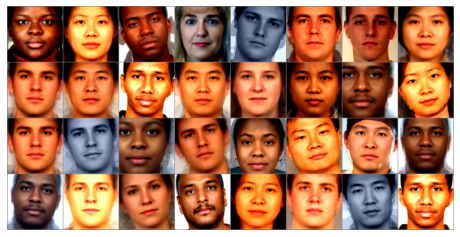

tensor([  0, 334,   0,  88, 194, 189, 141, 229, 379, 264, 216, 273, 238, 247,
        302, 224, 379, 400, 400, 299, 167,   0, 190, 400, 202, 327, 400,  79,
        245, 216, 317, 216])

In [63]:
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))
labels

In [13]:
# Create optimizers, loss functions and scheduler for scheduling learning rate

In [64]:
# Define a loss function

loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [65]:
# Test the forward pass with dummy data
out = net(torch.randn(2, 3, 224, 224, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 401])
Output logits:
[[ 9.42852534e-03  1.11145610e-02  6.18031062e-03  2.43914723e-02
  -8.35405290e-03  1.39728235e-02  1.08433906e-02  3.61039396e-03
   2.25389865e-03 -3.43813654e-03 -1.42211770e-03  2.77848989e-02
   1.79383364e-02 -8.42561480e-03  6.05378160e-03 -6.35610335e-03
   1.74792251e-04 -5.95605420e-03 -2.57291691e-03 -3.10263573e-03
  -1.53289679e-02 -2.02534790e-03 -1.38537632e-03 -7.85754528e-03
   1.34086385e-02  1.25253825e-02  1.24604534e-03 -5.91463409e-04
  -5.63950744e-04 -7.47246668e-05  1.34143839e-03  7.63527397e-03
  -1.82910287e-03  2.48626573e-03 -1.57028006e-03  4.81655588e-03
  -3.53469374e-03  7.11957226e-03 -2.71016243e-03 -5.66669041e-03
   1.23280194e-02 -1.22068850e-02 -1.96303334e-03 -1.61294173e-02
   6.72497228e-03  1.92131288e-02  1.06506571e-02  3.89465131e-04
  -1.05486177e-02  2.99679115e-04 -1.35741923e-02  6.73505897e-03
   1.30692236e-02  1.96388317e-03 -1.00212377e-02 -3.64705105e-03
   4.07515559e-03  7.73164

In [14]:
# Training loop using 100 epochs and validating results everu 100 steps of training

In [66]:
num_epochs = 100
validation_every_steps = 100

step = 0
net.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    print(epoch)
    train_accuracies_batches = []
    print(len(train_loader))
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        
        # Forward pass, compute gradients, perform one training step
        optimizer.zero_grad()
        
        # Forward
        output = net(inputs)
        loss = loss_fn(output, targets)   
        
        # backward
        loss.backward()

        # optimize
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                net.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")
            
    scheduler.step()

print("Finished training.")

0
117
Step 100     training accuracy: 0.2221875
             test accuracy: 0.3774193548387097
1
117
Step 200     training accuracy: 0.5079066265060241
             test accuracy: 0.5344086021505376
2
117
Step 300     training accuracy: 0.6841856060606061
             test accuracy: 0.6279569892473118
3
117
Step 400     training accuracy: 0.8054846938775511
             test accuracy: 0.7204301075268817
4
117
Step 500     training accuracy: 0.908203125
             test accuracy: 0.7860215053763441
5
117
Step 600     training accuracy: 0.9666666666666667
             test accuracy: 0.810752688172043
Step 700     training accuracy: 0.9453125
             test accuracy: 0.8462365591397849
6
117
Step 800     training accuracy: 0.9677933673469388
             test accuracy: 0.8612903225806452
7
117
Step 900     training accuracy: 0.9818672839506173
             test accuracy: 0.864516129032258
8
117
Step 1000    training accuracy: 0.99365234375
             test accuracy: 0.867741935483871

78
117
Step 9200    training accuracy: 1.0
             test accuracy: 0.8935483870967742
79
117
Step 9300    training accuracy: 1.0
             test accuracy: 0.8935483870967742
80
117
Step 9400    training accuracy: 1.0
             test accuracy: 0.8956989247311828
81
117
Step 9500    training accuracy: 1.0
             test accuracy: 0.8881720430107527
82
117
Step 9600    training accuracy: 1.0
             test accuracy: 0.8849462365591397
Step 9700    training accuracy: 1.0
             test accuracy: 0.886021505376344
83
117
Step 9800    training accuracy: 1.0
             test accuracy: 0.8935483870967742
84
117
Step 9900    training accuracy: 1.0
             test accuracy: 0.8913978494623656
85
117
Step 10000   training accuracy: 1.0
             test accuracy: 0.8881720430107527
86
117
Step 10100   training accuracy: 1.0
             test accuracy: 0.8903225806451613
87
117
Step 10200   training accuracy: 1.0
             test accuracy: 0.8849462365591397
88
117
Step 10300 

In [15]:
# Save trained model as pretrained for further usage

In [67]:
torch.save(net.state_dict(), './pytorch-models/cnn_ADAM_schlr_continuous.pth')

In [16]:
# plot proceedings of training -- train and validation accuracies

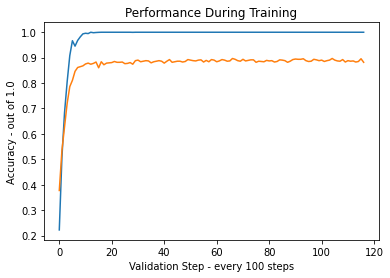

In [69]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_accuracies)),train_accuracies, label = 'Train Accuracy')
plt.plot(range(len(train_accuracies)),valid_accuracies, label = 'Test Accuracy')
plt.xlabel('Validation Step - every 100 steps')
plt.ylabel('Accuracy - out of 1.0')
plt.title("Performance During Training")
plt.savefig('train_test_acc_ADAM_analysis_increasedlr_continuous.jpg')
plt.show()

In [17]:
# Examples of misclassification cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


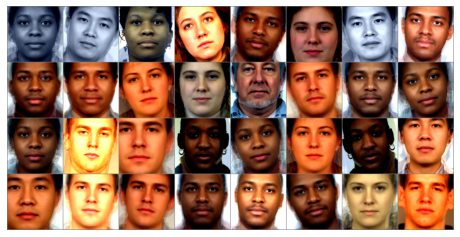

    TRUE        PREDICTED
-----------------------------
     394           394     
     273           273     
     367           367     
     138            0      
     247           247     
     176           176     
     202            0      
     132           132     
     305           305     
     250           250     
     290           290     
     176           176     
     106            0      
     327           327     
     247           247     
     400           400     
     400           400     
      0             0      
     400           379     
     220           220     
     335           335     
     290           290     
     220           220     
     150           150     
     400           400     
     400           400     
     299           299     
     301           301     
     400           400     
     302           302     
     238           238     
      0             0      


In [70]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")